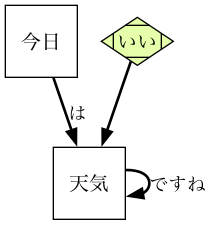

In [3]:
# リスト 3.1.4
# naruhodoを使った視覚的表示その1
# -----------------------------------------------------------------------------------
# 目的:
#   ・日本語文の「係り受け（依存関係）」や「文節構造」を、可視化ツール naruhodo で
#     手早く図示する最小例を示す。
#
# 理論メモ（実装は変えず背景のみ補足）:
#   ・係り受け解析は、各語（または文節）が「どの語（文節）に係るか」という有向木（依存木）を構成する。
#     可視化は、この木構造（ノード=語/文節, 辺=係り）を人間可読にする工程。
#   ・naruhodo は、内部の解析器（例: MeCab + CaboCha / spaCy+GiNZA など環境依存）で得た
#     構造をグラフに描画する“ラッパ”の位置づけ。したがって **使用する解析器・辞書の違い** が
#     可視化結果（分割境界・品詞・依存）に影響する点に注意。
#   ・`gtype="d"` は一般に **dependency（依存構造の可視化）** を意味する設定（ツール仕様に依存）。
#     他にチャンク単位などが選べる実装もあるが、本スニペットでは依存構造を前提とする。
#
# 実行環境メモ:
#   ・ノートブック環境では `dp.show()` がインライン描画、スクリプト環境では別ウィンドウ／HTML表示になることがある。
#   ・GUI を使えない環境（サーバ等）では、ライブラリが提供する保存 API（例: `dp.save("out.html")` など）を
#     使うのが安全（ここではコードを変更せず、コメントに留める）。
#   ・解析の再現性を確保したい場合、背後で使う辞書（IPADIC/UniDic/NEologd 等）とそのバージョンを記録する。
# -----------------------------------------------------------------------------------

from naruhodo import parser

# parser の生成:
# - lang="ja" : 日本語解析を選択。内部のトークナイザ/品詞体系は環境依存。
# - gtype="d" : dependency（係り受け）可視化モードの指定（実装仕様に依存）。
dp = parser(lang="ja", gtype="d")

# 解析対象文の追加:
# - add() に文を与えると、内部で形態素解析→（必要なら）チャンク化→依存推定が行われ、
#   可視化用のデータ構造に積まれる。
dp.add("今日はいい天気ですね")

# 可視化の実行:
# - ノートブック: セル出力として図が表示されることが多い。
# - スクリプト: ビューアが開く/HTML を生成する等、環境依存の動作になり得る。
# - 保存したい場合はライブラリ提供の保存機能（例: dp.save(...)）を利用（ここでは呼ばない）。
dp.show()

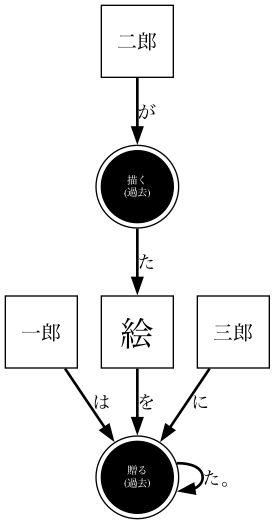

In [4]:
# リスト 3.1.5
# naruhodoを使った視覚的表示その2
# -----------------------------------------------------------------------------------
# 目的:
#   ・係り受け（依存）構造を、相互参照を含む日本語文で可視化する最小例。
#   ・文「一郎は二郎が描いた絵を三郎に贈った。」は、
#       - 主節述語: 「贈った」
#       - 主要項    : ガ格(主語/主題)「一郎は」、ヲ格(対象)「絵を」、ニ格(授与先)「三郎に」
#       - 連体修飾 : 「二郎が描いた」→ 名詞「絵」を修飾
#     といった典型的な日本語構文（授与表現＋連体節）を含むため、依存木の読み方を練習しやすい。
#
# 理論メモ（動作は変えず背景のみ補足）:
#   ・依存可視化は「ノード=語（または文節）」「辺=係り（修飾→被修飾）」の有向木を図示する。
#   ・連体節「二郎が描いた」は、節内の述語「描いた」から名詞「絵」へ係る（節→名詞）構造が期待される。
#   ・トピックマーカー「は」は情報構造（主題）を示すが、依存木上は多くの実装で「は」を含む文節が
#     述語「贈った」に係る（ガ格相当の主語扱いとは限らない）。係り受けは意味役割と必ずしも一致しない点に注意。
#   ・ヲ格「絵を」は主節の目的語として「贈った」に係るが、同時に「絵」は連体節の被修飾語でもある。
#     可視化では「絵」の周辺に「二郎/描いた」由来の枝が集約されるはず。
#
# ツール仕様メモ:
#   ・naruhodo は内部で形態素解析/依存解析（MeCab+係り受け器、spaCy+GiNZA など環境依存）を呼ぶラッパで、
#     解析器・辞書の差は可視化結果（分割・品詞・依存）に反映される。再現性を重視する場合は、辞書とバージョンを固定・記録する。
#   ・`gtype="d"` は dependency（依存構造）の可視化モード想定。
#   ・描画バックエンドは多くの環境で graphviz（dot/pydot）や networkx/nxpd に依存する。
#     バージョン不整合（例: networkx 3.x と nxpd のAPI差）で落ちることがあるため、動かない場合は
#     `networkx<3` を検討し、graphviz 本体（dot コマンド）と pydot の導入状況を確認する。
#
# 実行環境メモ:
#   ・ノートブックでは `dp.show()` がインライン描画、スクリプトでは別ビュー/ファイル生成になることがある。
#   ・保存が必要なら、ライブラリ側の保存APIがあれば（例: dp.save("out.png"/"out.html") など）利用する。
#     なければ内部グラフ dp.G を取り出して nxpd の draw で保存する実装も可能。
# -----------------------------------------------------------------------------------

# 必要に応じて import（同一ノートブックで前セルがあれば省略可）
from naruhodo import parser

# 依存構造の可視化器を生成
# - lang="ja": 日本語モード
# - gtype="d": dependency（係り受け）可視化
dp = parser(lang="ja", gtype="d")

# 解析対象文の投入
# - 主節: 「贈った」←（ガ/主題）「一郎は」,（ヲ）「絵を」,（ニ）「三郎に」
# - 連体節: 「二郎が描いた」→ 名詞「絵」を修飾
dp.add("一郎は二郎が描いた絵を三郎に贈った。")

# 可視化の実行
# - ノートブック: 図がセル出力に埋め込まれる
# - スクリプト   : 環境により表示/保存動作が変わる
dp.show()

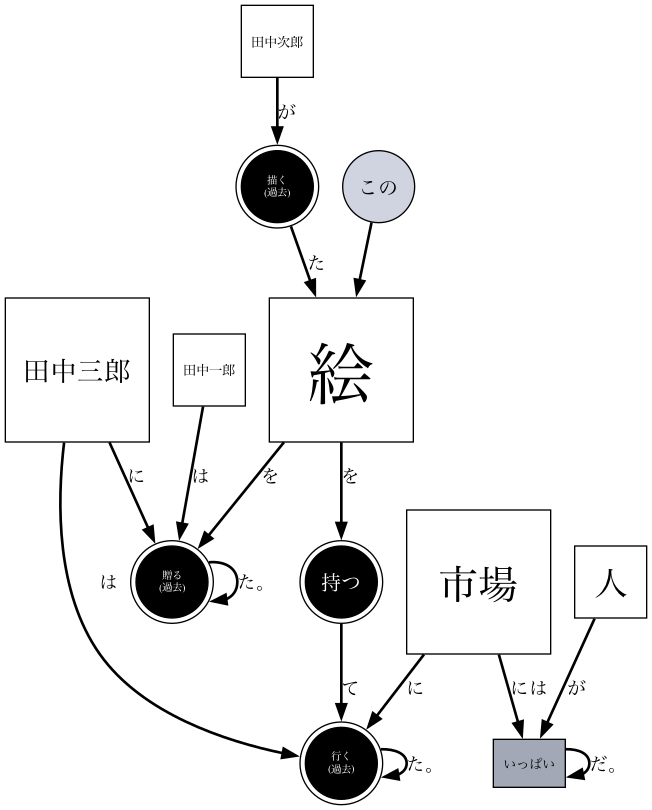

In [5]:
# リスト 3.1.6
# naruhodoを使った視覚的表示その2（複数文の順次追加と可視化）
# -----------------------------------------------------------------------------------
# 目的:
#   ・naruhodo の可視化器に対し、複数の日本語文を「順序どおりに」追加し、
#     係り受け（依存）構造を連続して図示する最小例を示す。
#
# 理論メモ（動作は変えず背景のみ補足）:
#   ・各文は内部で「形態素解析→（必要なら）文節化→依存解析」され、依存木として可視化される。
#   ・文間の照応（例: 2文目の「この絵」≒1文目の「絵」）は、通常の依存解析の範囲外。
#     したがって “文内の木” は得られるが、“文間リンク（コア参照）”は描かれないのが普通。
#   ・dp.reset() は既存のグラフ状態を破棄し、新しいセッションを開始するための操作。
#     連続実行で前の結果が混ざらないように最初に呼ぶのが安全。
#   ・可視化は解析器・辞書（IPADIC/UniDic/NEologd など）と描画バックエンド（graphviz, nxpd）
#     のバージョンに依存して結果（分割・品詞・見た目）が揺れ得る。再現性を重視するなら
#     それらのバージョンを固定・記録しておく。
#
# 使い方メモ:
#   ・このスニペットは前セルで `from naruhodo import parser; dp = parser(lang="ja", gtype="d")`
#     が既に実行されている前提。未実行なら上記2行を追加してから使う。
#   ・gtype="d" は dependency（係り受け）可視化モード想定。
# -----------------------------------------------------------------------------------

# グラフの初期化
# - 直前の解析結果（ノード・エッジ）をすべてクリアし、新しいキャンバスを用意する。
dp.reset()

# 文を順番に沿って追加
# 1文目: 授与構文 + 連体節
#   「田中次郎が描いた」→「絵」を連体修飾し、主節では「絵を（ヲ格）」「田中三郎に（ニ格）」「田中一郎は（主題）」が
#   述語「贈った」に係る構造が期待される。
dp.add("田中一郎は田中次郎が描いた絵を田中三郎に贈った。")

# 2文目: 代名詞指示「この絵」
#   文内では「この（連体詞）」→「絵」を修飾し、「絵を（ヲ格）」→「行った（移動動詞）」と
#   「市場に（ニ格）」が係る構造が想定される。
#   ※ 「この絵」≒ 1文目の「絵」という“文間の照応”は通常の依存解析では線が引かれない。
dp.add("田中三郎はこの絵を持って市場に行った。")

# 3文目: 叙述文（存在/状態）
#   「市場には（ニ格提示）」→「いっぱいだ（述語）」、主語相当の「人が（ガ格）」→「いっぱいだ」に係る
#   シンプルな依存木が期待される。
dp.add("市場には人がいっぱいだ。")

# 図を表示
# - ノートブックではインライン描画。スクリプト環境ではビュー/ファイル出力の挙動が環境依存。
# - もし描画に失敗する場合は、graphviz（dot）と pydot、networkx/nxpd のバージョン整合を確認する。
dp.show()